In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import os
import gc
import time
import importlib
import sklearn.preprocessing as pp
import sklearn.model_selection as ms
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from recommender import item_based, dummy as dummy_recommender, preprocessing as rpp, model_selection as rms,\
    tools as rtools
import tag_genome_builder as tg_builder
from tag_genome_builder import model_selection as ms_tg_builder

from lib import tools
import config
import config_tag_recommender
def reload():
    importlib.reload(item_based)
    importlib.reload(dummy_recommender)
    importlib.reload(config)
    importlib.reload(tg_builder)
    importlib.reload(rpp)
    importlib.reload(rms)
    importlib.reload(tools)
    importlib.reload(config_tag_recommender)
    importlib.reload(ms_tg_builder)
    importlib.reload(rtools)
    
    

# input params

In [2]:
reload()
str_aggregated_path = config_tag_recommender.str_aggregated_path
str_genome_scores = config_tag_recommender.str_genome_scores
str_tag_ids = config_tag_recommender.str_tag_ids
str_rating_path = config_tag_recommender.str_rating_path
str_data_folder = config_tag_recommender.str_data_folder
minimum_no_of_frames = config_tag_recommender.minimum_no_of_frames
number_of_tag_per_movie = config_tag_recommender.number_of_tag_per_movie
n_jobs = 10

In [3]:
print('str_aggregated_path =', str_aggregated_path)
print('str_genome_scores =', str_genome_scores)
print('str_tag_ids =', str_tag_ids)
print('str_rating_path =', str_rating_path)
print('str_data_folder =', str_data_folder)
print('str_aggregated_path =', str_aggregated_path)
print('minimum_no_of_frames =', minimum_no_of_frames)
print('number_of_tag_per_movie =', number_of_tag_per_movie)

str_aggregated_path = C:\Users\shossein\Dropbox\Original Data\Elahi LowLevel Features\Mise-en-Scene Dataset_v1\LLVisualFeatures13K_Log.csv
str_genome_scores = ..\..\data\ml-25m\genome-scores.csv
str_tag_ids = ..\..\data\ml-25m\genome-tags.csv
str_rating_path = ..\..\data\ml-25m\ratings.csv
str_data_folder = ..\..\data
str_aggregated_path = C:\Users\shossein\Dropbox\Original Data\Elahi LowLevel Features\Mise-en-Scene Dataset_v1\LLVisualFeatures13K_Log.csv
minimum_no_of_frames = 10
number_of_tag_per_movie = 10


# Read inputs

In [4]:
df_tag_ids = pd.read_csv(str_tag_ids, index_col=config.tagId_col)

In [5]:
# df_tag_ids.head()

In [6]:
df_genome = pd.read_csv(str_genome_scores)

In [7]:
df_ratings = pd.read_csv(str_rating_path)

In [8]:
# usecols = ['movieId', 'no_key_frames']
# for i in range(1,11):
#     usecols += [f'f{i}_median', f'f{i}_quartile1', f'f{i}_quartile3', f'f{i}_std'] 
# print(len(usecols))
usecols = None


df_agg = pd.read_csv(str_aggregated_path, nrows=None, usecols=usecols, index_col=config.movieId_col).sort_index()
# df_agg = df_agg[df_agg['no_key_frames'] >= minimum_no_of_frames]
df_agg.dropna(axis=1, thresh=len(df_agg) - 1000, inplace=True)

In [9]:
print('The size of datasets before filtering to the same:')
print('VF:', df_agg.shape,'Tag genome:', df_genome[config.movieId_col].nunique())
df_agg, df_genome = tg_builder.Base().filter_tag_and_vf_to_same(df_agg=df_agg, df_genome_scores=df_genome)
print('The size of datasets after filtering to the same:')
print('VF:', df_agg.shape,'Tag genome:', df_genome[config.movieId_col].nunique())

The size of datasets before filtering to the same:
VF: (13373, 7) Tag genome: 13816
The size of datasets after filtering to the same:
VF: (6359, 7) Tag genome: 6359


In [10]:
vf_item_features =rpp.ItemFeature()
vf_item_features.from_dataframe(df_agg)

In [11]:
item_features = rpp.get_item_feature_from_tag_genome(df_genome, number_of_tag_per_movie)

In [12]:
df_ratings_filtered = df_ratings[df_ratings[config.movieId_col].isin(item_features.item_ids)]
user_activities = df_ratings_filtered[config.userId_col].value_counts()
df_ratings_filtered = df_ratings_filtered[df_ratings_filtered[config.userId_col].\
                                          isin(user_activities[user_activities > 1].index)]

# Compute tag genome based on visual features

In [13]:
normalizer = pp.QuantileTransformer(output_distribution='normal')
# normalizer = pp.StandardScaler()


In [14]:
%%time
reload()
df_predicted_tag_genome = ms_tg_builder.cross_val_predict(df_visual_features=df_agg,
                                                          df_genome_scores=df_genome,
                                                          normalizer_vf=normalizer,
                                                          n_splits=10, 
                                                          n_jobs=n_jobs)


Wall time: 20.5 s


In [15]:
item_features_vf_tg = rpp.get_item_feature_from_tag_genome(df_predicted_tag_genome, number_of_tag_per_movie)

# Dump to disk

In [16]:
# vf_normalizer0 = tg_builder.VisualFeatureNormalizer()
# normalizer0 = pp.QuantileTransformer()
# df_agg_norm = vf_normalizer0.fit_transform(df_agg, normalizer0)

In [17]:
# df_agg_norm.to_csv('./output/processed_data/df_aggregated_vf_normalized.csv')

# df_ratings_filtered.to_csv('./output/processed_data/df_rating_filtered.csv', index=False)

# df_predicted_tag_genome.to_csv('./output/processed_data/df_predicted_tag_genome.csv', index=False)

# df_tag_features = pd.DataFrame(item_features.feature_matrix.toarray(),
#                               index=item_features.item_ids,
#                               columns=item_features.feature_names)
# df_tag_features.index.name = config.movieId_col

# df_tag_features.to_csv('./output/processed_data/df_movie_tag_features.csv')

# Train test split
## rating dataset and tag item features

In [18]:
reload()
df_rating_train, df_rating_test, item_features_train, item_features_test = \
    rms.train_test_split(df_ratings_filtered, item_features, strategy='sklearn', test_size=.25)

# rate_normalizer = rpp.RatingNormalizer()
# df_rating_train[config.rating_col] = rate_normalizer.fit_transform(df_rating_train)
# df_rating_test[config.rating_col] = rate_normalizer.transform(df_rating_test)

## tag genome computed using visual features

In [19]:
reload()
item_features_vf_tg_train, item_features_vf_tg_test = \
(item_features_vf_tg.get_item_feature_by_list_of_items(df_rating_train[config.movieId_col].unique()),
item_features_vf_tg.get_item_feature_by_list_of_items(df_rating_test[config.movieId_col].unique()))

## Visual features

In [20]:
vf_normalizer = tg_builder.VisualFeatureNormalizer()
normalizer = pp.StandardScaler()
df_agg_train = df_agg.loc[df_rating_train[config.movieId_col].unique()]
df_agg_train_normalized = vf_normalizer.fit_transform(df_agg_train, normalizer)
df_agg_test = df_agg.loc[df_rating_test[config.movieId_col].unique()]
df_agg_test_normalized = vf_normalizer.transform(df_agg_test)

item_features_vf_train = rpp.ItemFeature()
item_features_vf_train.from_dataframe(df_agg_train_normalized)
item_features_vf_test = rpp.ItemFeature()
item_features_vf_test.from_dataframe(df_agg_test_normalized)


In [21]:
len(df_agg_test), len(df_agg_train)

(6359, 6359)

In [22]:
len(df_agg_test_normalized), len(df_agg_train_normalized)

(6359, 6359)

# Explore

1

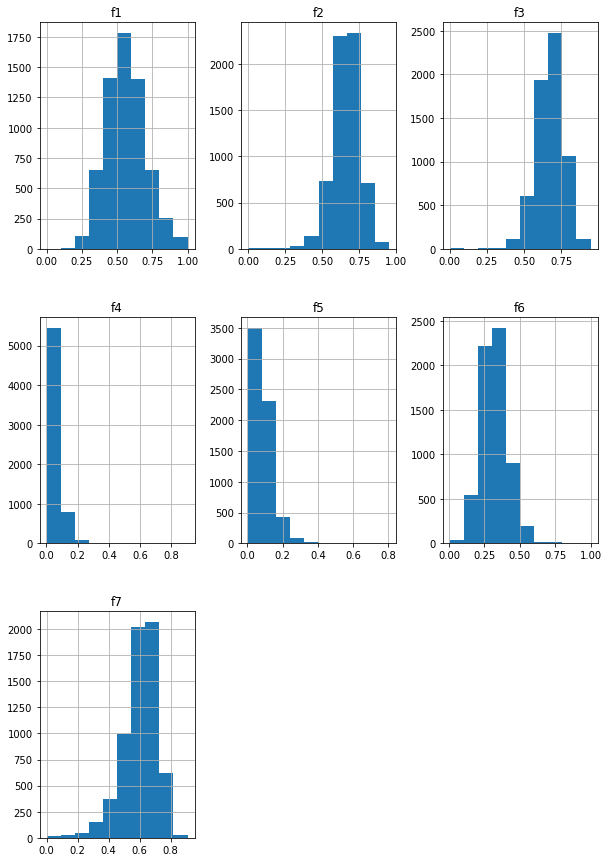

In [23]:
df_agg.hist(figsize=(10, 15))
1

1

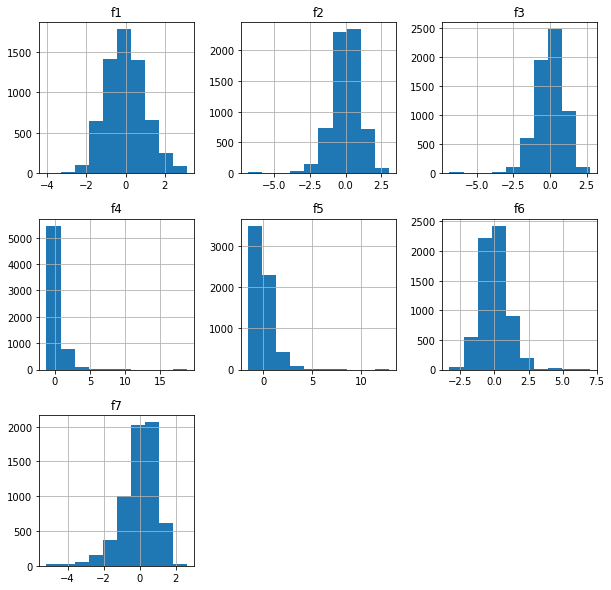

In [24]:
item_features_vf_train.to_dataframe().hist(figsize=(10, 10))
1

1

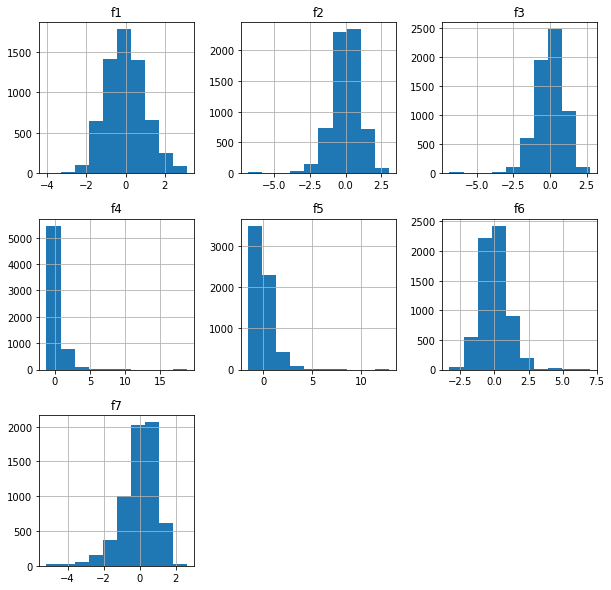

In [25]:
item_features_vf_test.to_dataframe().hist(figsize=(10, 10))
1

In [26]:
similarities_vf = metrics.pairwise.cosine_similarity(item_features_vf_test.feature_matrix)

1

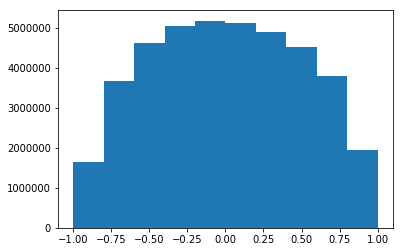

In [27]:
plt.hist(similarities_vf.ravel())
1

# Dump train and tests to disk

In [28]:
# df_agg_train_normalized.to_csv('./output/processed_data/df_aggregated_vf_train_normalized.csv')
# df_agg_test_normalized.to_csv('./output/processed_data/df_aggregated_vf_test_normalized.csv')

In [29]:
# df_rating_train.to_csv('./output/processed_data/df_rating_train.csv', index=False)
# df_rating_test.to_csv('./output/processed_data/df_rating_test.csv', index=False)

In [30]:
# item_features_vf_tg_train.to_dataframe().to_csv('./output/processed_data/df_predicted_tag_genome_features_train.csv')
# item_features_vf_tg_test.to_dataframe().to_csv('./output/processed_data/df_predicted_tag_genome_features_test.csv')

# # df_predicted_tag_genome.to_csv('./output/processed_data/df_predicted_tag_genome.csv', index=False)

In [31]:
# item_features_train.to_dataframe().to_csv('./output/processed_data/df_movie_tag_features_train.csv')
# item_features_test.to_dataframe().to_csv('./output/processed_data/df_movie_tag_features_test.csv')

# Train the content based recommender and predict on test on VF

In [32]:
reload()
recommend_vf = item_based.ItemBasedColabCos()
recommend_vf.fit(df_rating_train, item_features_vf_train)

In [33]:
test_users = df_rating_test[config.userId_col].unique()

In [34]:
print(len(test_users))

162490


## Explore 

In [41]:
sample_test_users = np.random.choice(test_users, 5)


In [78]:
from scipy.stats import shapiro
from scipy.stats import normaltest
from tqdm import tqdm_notebook as tqdm

In [91]:
def get_normality_stats(sample_user):
    """returns [0, 25, 50, 75, 100] percentile of similarities and p value of normltest"""
    user_info = recommend_vf.dict_user_ratings.get(sample_user)
    similarities = metrics.pairwise.cosine_similarity(recommend_vf.get_user_matrix(user_info))
    similarities = similarities.ravel()
    try:
        stat, p = normaltest(similarities)
    except ValueError:
        p = np.nan
    return np.append(np.percentile(similarities, [0, 25, 50, 75, 100]), [p])

In [92]:
normalities = []
for sample_user in tqdm(test_users, total=len(test_users)):
    normalities.append(get_normality_stats(sample_user))
df_normalities = pd.DataFrame(normalities, columns=['min', 'p25', 'p50', 'p75', 'max', 'p_value'])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9


In [93]:
df_normalities.describe()

,min,p25,p50,p75,max,p_value
count,162490.000000,162490.000000,162490.000000,162490.000000,1.624900e+05,1.624700e+05
mean,-0.932460,-0.317715,0.079322,0.492546,1.000000e+00,6.532185e-03
std,0.076740,0.089607,0.089031,0.081570,3.372102e-16,4.520544e-02
min,-0.999346,-0.875730,-0.356005,0.108667,1.000000e+00,0.000000e+00
25%,-0.978638,-0.373213,0.019775,0.432849,1.000000e+00,1.505974e-229
50%,-0.955031,-0.340092,0.057480,0.474388,1.000000e+00,1.655885e-40
75%,-0.910476,-0.281478,0.114687,0.531339,1.000000e+00,6.281687e-10
max,0.721809,0.800972,0.960090,1.000000,1.000000e+00,9.994044e-01


1

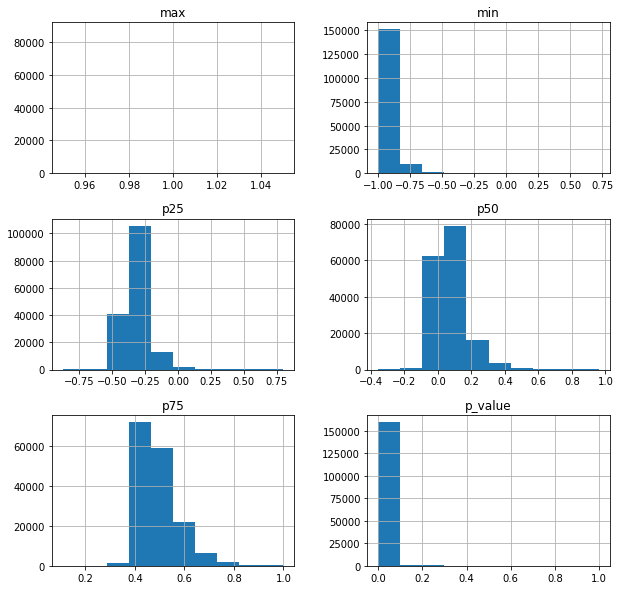

In [95]:
df_normalities.hist(figsize=(10,10), log=False)
1

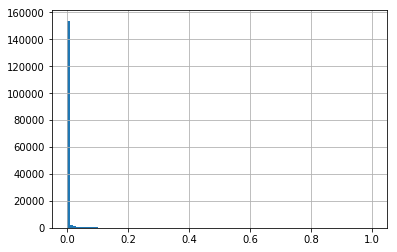

In [97]:
df_normalities.p_value.hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024EC27C6710>,
      dtype=object)

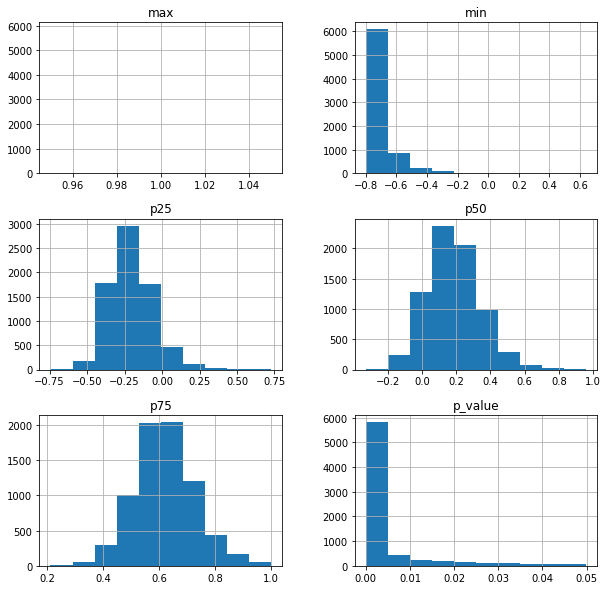

In [103]:
df_normalities[(df_normalities.p_value < .05) & (df_normalities['min'] > -.8)].hist(figsize=(10,10))

## Predict

In [35]:
# %%time
# df_recommendation_vf_list = recommend_vf.predict_on_list_of_users_vectorize(users=test_users,
#                                                                             new_items=item_features_vf_test)

In [36]:
%%time
recommendations_vf = recommend_vf.predict_on_list_of_users(test_users, 
                                                           df_rating_test, 
                                                           item_features_vf_test, 
                                                           n_jobs=1,
                                                           min_similarity=.6)

C:\Users\shossein\Documents\personal\research\visual_features\src\recommender\item_based.py:64: RuntimeWarning: invalid value encountered in true_divide
  new_ratings = similarities_weighted.sum(axis=1) / abs(similarities).sum(axis=1)



Wall time: 37min 35s


In [37]:
reload()
df_rating_test = rtools.prepare_recommendations_df(df_rating_test=df_rating_test,
                                                   recommendations=recommendations_vf, 
                                                   prediction_column_suffix='vf')

In [38]:
recommend_vf.dict_sat_to_zero

{1: 0.8701298701298701,
 2: 0.8451548451548452,
 3: 0.8210583742498636,
 4: 0.8546238244514106,
 5: 0.860969387755102,
 6: 0.9333333333333333,
 7: 0.9642857142857143,
 8: 0.8517333333333333,
 9: 0.8482603092783505,
 10: 0.8376068376068376,
 11: 0.9230769230769231,
 12: 0.8532608695652174,
 13: 0.8396542827657378,
 14: 0.9629629629629629,
 15: 0.8611111111111112,
 16: 0.8863636363636364,
 17: 0.7954545454545454,
 18: 0.8711734693877551,
 19: 0.8531081081081081,
 20: 0.8663101604278075,
 21: 0.8333333333333334,
 22: 0.8846153846153846,
 23: 0.8604182413706223,
 24: 0.875,
 25: 0.8414634146341463,
 26: 0.8529411764705882,
 27: 0.8663101604278075,
 28: 0.8888888888888888,
 29: 0.8428571428571429,
 30: 0.803921568627451,
 31: 0.8554671562627499,
 32: 0.8269230769230769,
 33: 0.8518518518518519,
 34: 0.8611111111111112,
 35: 0.8888888888888888,
 36: 0.8717647058823529,
 37: 0.8385416666666666,
 38: 0.8536883991429446,
 39: 0.696969696969697,
 40: 0.8744939271255061,
 41: 0.8420902341519132,


In [39]:
wait

NameError: name 'wait' is not defined

# Train the content based recommender and predict on test on original tag genome

In [ ]:
reload()

In [ ]:
recommend = item_based.ItemBasedColabCos()
recommend.fit(df_rating_train, item_features_train)

In [ ]:
%%time
test_users = df_rating_test[config.userId_col].unique()
recommendations = recommend.predict_on_list_of_users(test_users, df_rating_test, item_features_test, n_jobs=n_jobs)

In [ ]:
df_rating_test = rtools.prepare_recommendations_df(df_rating_test=df_rating_test,
                                                    recommendations=recommendations, 
                                                    prediction_column_suffix='tg')

# Train the content based recommender and predict on test on VF tag genome

In [ ]:
recommend_vf_tg = item_based.ItemBasedColabCos()
recommend_vf_tg.fit(df_rating_train, item_features_vf_tg_train)

In [ ]:
%%time
test_users_vf = df_rating_test[config.userId_col].unique()
recommendations_vf_tg = recommend_vf_tg.\
    predict_on_list_of_users(test_users_vf, df_rating_test, item_features_vf_tg_test, n_jobs=n_jobs)

In [ ]:
df_rating_test = rtools.prepare_recommendations_df(df_rating_test=df_rating_test,
                                                   recommendations=recommendations_vf_tg, 
                                                   prediction_column_suffix='vf_tg')

# Train the baseline recommender and predict on test

In [ ]:
reload()
recommend_dummy = dummy_recommender.DummyAverageUser()
recommend_dummy.fit(df_rating_train, item_features_train)

In [ ]:
%%time
recommendations_dummy = recommend_dummy.predict_on_list_of_users(test_users, 
                                                                 df_rating_test, 
                                                                 item_features_test, 
                                                                 n_jobs=n_jobs)


In [ ]:
reload()
df_rating_test = rtools.prepare_recommendations_df(df_rating_test=df_rating_test,
                                                   recommendations=recommendations_dummy, 
                                                   prediction_column_suffix='average_user')

# Train the 2nd baseline recommender and predict on test

In [ ]:
reload()
recommend_dummy2 = dummy_recommender.DummyAverageItem()
recommend_dummy2.fit(df_rating_train, item_features_train)

In [ ]:
%%time
recommendations_dummy2 = recommend_dummy2.predict_on_list_of_users(test_users, 
                                                                   df_rating_test, 
                                                                   item_features_test, 
                                                                   n_jobs=n_jobs)


In [ ]:
reload()
df_rating_test = rtools.prepare_recommendations_df(df_rating_test=df_rating_test,
                                                   recommendations=recommendations_dummy2, 
                                                   prediction_column_suffix='average_item')

# looking at the performance

1

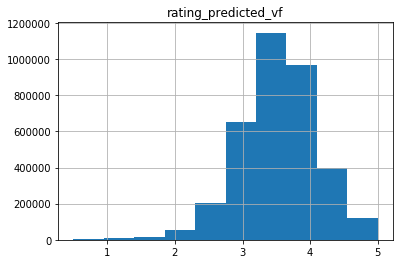

In [40]:
df_rating_test.filter(regex='rating_predicted').hist()
1

In [41]:
prediction_column_suffixes = []
for c in df_rating_test.filter(regex='rating_predicted').columns:
    c = c.replace('rating_predicted', '')
    c = c[1:] if len(c) > 0 else c
    prediction_column_suffixes.append(c)
prediction_column_suffixes

['vf']

In [42]:
reload()
df_performance_report = pd.concat([tools.performance_report(df_rating_test, 
                                                           prediction_column_suffix=alg) 
                                  for alg in prediction_column_suffixes]).sort_values('RMSE')
df_performance_report

,Average Score,MAE,RMSE,NRMSE,R2,Std of residuals,Avg of residuals
vf,3.528882,0.765757,0.996527,0.282392,0.118981,0.996524,0.002237


## performance table for copying into Latex

In [ ]:
print(df_performance_report.to_latex())

## Some plots

In [ ]:
df_rating_test[config.rating_col].hist()

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_prediction_histogram,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_actual_vs_prediction,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes,
                            alpha=.1)

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_actual_vs_predicted_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_residual_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_absolute_residual_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

In [ ]:
# reload()
# _ = tools.plot_side_by_side(tools.plot_actual_vs_predicted_violinplot,
#                             df_rating_pred=df_rating_test,
#                             prediction_column_suffixes=prediction_column_suffixes)

# Save the current notebook into results folder and push to the repository

In [ ]:
wait

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
from notebook import notebookapp
import urllib
import json
import os
import ipykernel

currentTime = lambda : time.strftime('%Y-%m-%d-%H%M')
def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None

notebook_dir, notebook_name = os.path.split(notebook_path())
output = os.path.join(notebook_dir, 'output', f'{notebook_name}_{currentTime()}.ipynb')
os.system(f'jupyter nbconvert --to ipynb {notebook_path()} --output {output}')
os.system(f'git add {output}')
os.system(f'git commit -m "result computed on {currentTime()}"')
os.system('git push')

In [ ]:
df_rating_test.to_csv(os.path.join(notebook_dir, 'output', f'{notebook_name}_{currentTime()}_df_rating_test.csv'))